## Imports and Setup


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gc
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!unzip -q "/content/drive/MyDrive/Skin-Cancer-Detection/data/all_classification/all_classification.zip" -d "/content/all_classification"

In [ ]:
csv_path = "/content/all_classification/all_classification.csv"
image_root = "/content/all_classification/all_images"

In [ ]:
df_all = pd.read_csv(csv_path)
df_all['path'] = df_all['path'].apply(
    lambda x: os.path.join(image_root, os.path.basename(x)))
df_all

,image_name,diagnosis,benign_malignant,target,path
0,ISIC_0149568,mel,malignant,1,/content/all_classification/all_images/ISIC_01...
1,ISIC_0188432,mel,malignant,1,/content/all_classification/all_images/ISIC_01...
2,ISIC_0207268,mel,malignant,1,/content/all_classification/all_images/ISIC_02...
3,ISIC_0232101,mel,malignant,1,/content/all_classification/all_images/ISIC_02...
4,ISIC_0247330,mel,malignant,1,/content/all_classification/all_images/ISIC_02...
...,...,...,...,...,...
25282,ISIC_0073247,bcc,malignant,1,/content/all_classification/all_images/ISIC_00...
25283,ISIC_0073248,bkl,benign,0,/content/all_classification/all_images/ISIC_00...
25284,ISIC_0073249,mel,malignant,1,/content/all_classification/all_images/ISIC_00...
25285,ISIC_0073251,nv,benign,0,/content/all_classification/all_images/ISIC_00...


## Constants


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
model_dir = "/content/drive/MyDrive/Skin-Cancer-Detection/models"


def predict_keras(model_path, generator):
    tf.keras.backend.clear_session()
    model = load_model(model_path)
    preds = model.predict(generator, verbose=0)
    del model
    tf.keras.backend.clear_session()
    return preds

## Ensemble Functions


In [ ]:
def melanoma_ensemble(df):
    df = df.copy()
    df['label'] = 0
    gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        df, x_col='path', y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        shuffle=False, class_mode='raw', validate_filenames=False
    )
    x = predict_keras(os.path.join(
        model_dir, "melanoma_models/xception_finetuned.keras"), gen)
    d = predict_keras(os.path.join(
        model_dir, "melanoma_models/densenet_finetuned.keras"), gen)
    c = predict_keras(os.path.join(
        model_dir, "melanoma_models/cnn_model.keras"), gen)
    return (0.4 * x + 0.3 * d + 0.3 * c).flatten()


def nevus_ensemble(df):
    df = df.copy()
    df['label'] = 0
    gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        df, x_col='path', y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        shuffle=False, class_mode='raw', validate_filenames=False
    )
    x = predict_keras(os.path.join(
        model_dir, "nevus_models/xception_finetuned.keras"), gen)
    d = predict_keras(os.path.join(
        model_dir, "nevus_models/densenet_finetuned.keras"), gen)
    c = predict_keras(os.path.join(
        model_dir, "nevus_models/cnn_finetuned.keras"), gen)
    return (0.35 * x + 0.55 * d + 0.1 * c).flatten()


def binary_ensemble(df):
    df = df.copy()
    df['label'] = 0
    gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        df, x_col='path', y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        shuffle=False, class_mode='raw', validate_filenames=False
    )
    x = predict_keras(os.path.join(
        model_dir, "binary_models/xception_finetuned.keras"), gen)
    d = predict_keras(os.path.join(
        model_dir, "binary_models/densenet_finetuned.keras"), gen)
    c = predict_keras(os.path.join(
        model_dir, "binary_models/cnn_finetuned.keras"), gen)
    return (0.3 * d + 0.3 * x + 0.4 * c).flatten()


def malignant_ensemble(df):
    valid_classes = ['akiec', 'bcc']
    df = df[df['diagnosis'].isin(valid_classes)].copy()
    gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        df, x_col='path', y_col='diagnosis',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        shuffle=False, class_mode='categorical', validate_filenames=False
    )
    x = predict_keras(os.path.join(
        model_dir, "malignant_models/xception_model.keras"), gen)
    d = predict_keras(os.path.join(
        model_dir, "malignant_models/densenet_finetuned.keras"), gen)
    c = predict_keras(os.path.join(
        model_dir, "malignant_models/cnn_finetuned.keras"), gen)
    return np.argmax(0.2 * x + 0.4 * d + 0.4 * c, axis=1), list(gen.class_indices.keys())


def benign_ensemble(df):
    valid_classes = ['bkl', 'df', 'vasc']
    df = df[df['diagnosis'].isin(valid_classes)].copy()
    gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        df, x_col='path', y_col='diagnosis',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        shuffle=False, class_mode='categorical', validate_filenames=False
    )
    x = predict_keras(os.path.join(
        model_dir, "benign_models/xception_finetuned.keras"), gen)
    d = predict_keras(os.path.join(
        model_dir, "benign_models/densenet_model.keras"), gen)
    c = predict_keras(os.path.join(
        model_dir, "benign_models/cnn_finetuned.keras"), gen)
    return np.argmax(0.2 * x + 0.6 * d + 0.2 * c, axis=1), list(gen.class_indices.keys())

## Pipeline


In [ ]:
def run_classification_pipeline(df):
    df = df.copy()
    df['pred'] = None

    # Melanoma
    mel_scores = melanoma_ensemble(df)
    mel_idx = mel_scores > 0.5
    df.loc[mel_idx, 'pred'] = 'mel'
    print(f"Melanoma classified: {mel_idx.sum()}")

    # Nevus
    df_nevus = df[df['pred'].isna()].copy()
    nevus_scores = nevus_ensemble(df_nevus)
    nevus_idx = nevus_scores < 0.5
    df.loc[df_nevus.index[nevus_idx], 'pred'] = 'nv'
    print(f"Nevus classified: {nevus_idx.sum()}")

    # Binary Classification
    df_bin = df[df['pred'].isna()].copy()
    binary_scores = binary_ensemble(df_bin)
    mal_idx = binary_scores > 0.5
    ben_idx = ~mal_idx
    df.loc[df_bin.index[mal_idx], 'pred'] = 'malignant'
    df.loc[df_bin.index[ben_idx], 'pred'] = 'benign'
    print(f"Malignant: {mal_idx.sum()}, Benign: {ben_idx.sum()}")

    # Malignant Subtypes
    df_mal = df[(df['pred'] == 'malignant') & (
        df['diagnosis'].isin(['akiec', 'bcc']))].copy()
    if not df_mal.empty:
        mal_preds, mal_labels = malignant_ensemble(
            df_mal.reset_index(drop=True))
        final_labels = [mal_labels[p] for p in mal_preds]
        df.loc[df_mal.index, 'pred'] = final_labels
        print(
            f"Malignant subtype breakdown: {dict(pd.Series(final_labels).value_counts())}")

    # Benign Subtypes
    df_ben = df[(df['pred'] == 'benign') & (
        df['diagnosis'].isin(['bkl', 'df', 'vasc']))].copy()
    if not df_ben.empty:
        ben_preds, ben_labels = benign_ensemble(df_ben.reset_index(drop=True))
        final_labels = [ben_labels[p] for p in ben_preds]
        df.loc[df_ben.index, 'pred'] = final_labels
        print(
            f"Benign subtype breakdown: {dict(pd.Series(final_labels).value_counts())}")

    return df

In [ ]:
df_all = run_classification_pipeline(df_all)

Found 25287 non-validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Melanoma classified: 7477
Found 17810 non-validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Nevus classified: 11028
Found 6782 non-validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Malignant: 3870, Benign: 2912
Found 3342 non-validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Malignant subtype breakdown: {'bcc': np.int64(2233), 'akiec': np.int64(1109)}
Found 2024 non-validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Benign subtype breakdown: {'bkl': np.int64(1405), 'df': np.int64(362), 'vasc': np.int64(257)}


## Evaluation


In [ ]:
true_labels = df_all['diagnosis']
pred_labels = df_all['pred']

In [ ]:
unique_labels = np.unique(true_labels)

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, labels=unique_labels))


Classification Report:
              precision    recall  f1-score   support

       akiec       0.47      0.60      0.53       867
         bcc       0.97      0.65      0.78      3323
         bkl       0.99      0.53      0.69      2624
          df       0.43      0.65      0.52       239
         mel       0.61      0.89      0.72      5106
          nv       0.95      0.81      0.88     12875
        vasc       0.81      0.82      0.82       253

   micro avg       0.82      0.77      0.79     25287
   macro avg       0.75      0.71      0.70     25287
weighted avg       0.87      0.77      0.80     25287



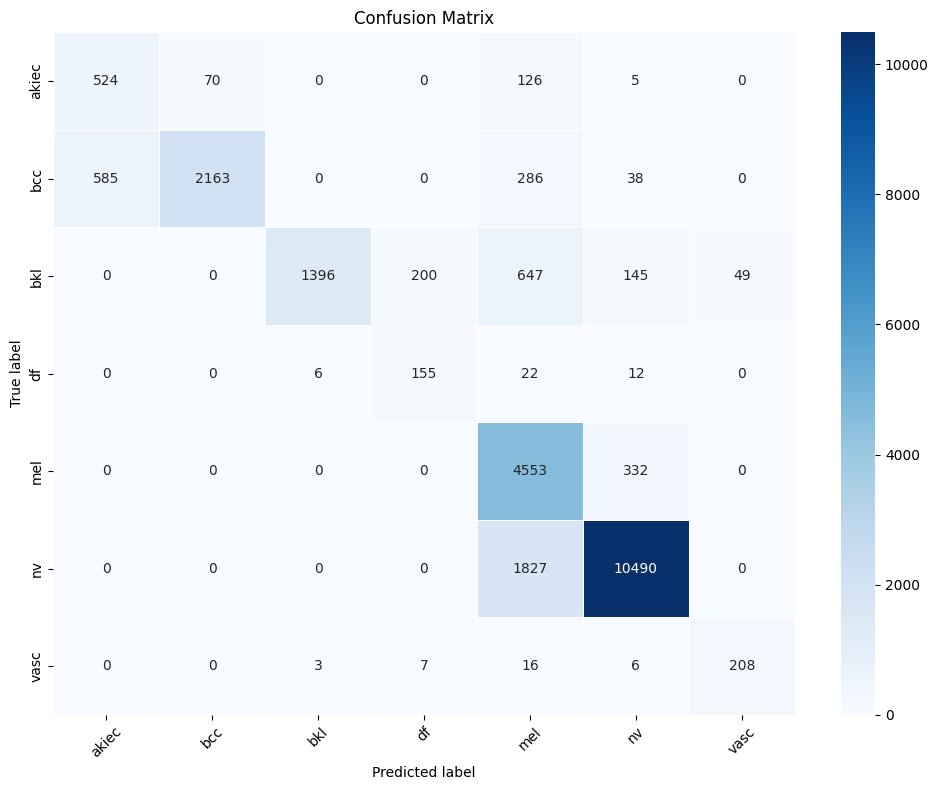

In [ ]:
cm = confusion_matrix(true_labels, pred_labels, labels=unique_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels, linewidths=0.5)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()